Experiment 1: Visualizing Input Time Series with Mean Overlay for Enhanced Readability


Objective: To improve interpretability by overlaying mean values on raw time series data, enabling visual identification of patterns such as trends and seasonality. This also serves as a foundation for developing visualization strategies for counterfactual explanations (CFE) in future experiments.

### With Focus on P3 FLUX Counterfactuals ###

In [59]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dice_ml
from sklearn.preprocessing import MinMaxScaler
import warnings
import random
from scripts.SEP_CFE_functions import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings("ignore")

In [60]:
wandb.init(
    entity="gsu-dmlab",
    project="SEPCFE",  # You choose the project name
    name="Exp2_Visualization",
)

In [61]:
abt_path_train = '../data/raw/mean_sliced/train_data.csv'
df_train = pd.read_csv(abt_path_train,  sep=',',index_col=0)

In [62]:
df_train["Event_Y_N"] = df_train['Label'].replace({0:1, -1:0})
min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(df_train.drop(["Label","Event_Y_N"],axis=1))
X_train = df_train.drop(["Label","Event_Y_N"],axis=1)
Y_train=df_train["Event_Y_N"]

In [63]:
abt_path_test = '../data/raw/mean_sliced/test_data.csv'
df_test = pd.read_csv(abt_path_test, sep=',',index_col=0)

In [64]:
df_test["Event_Y_N"] = df_test['Label'].replace({0:1, -1:0})
# X_test = min_max_scaler.fit_transform(df_test.drop(["Label","Event_Y_N"],axis=1))
X_test = df_test.drop(["Label","Event_Y_N"],axis=1)
Y_test=df_test["Event_Y_N"]

In [65]:
abt_path_val = '../data/raw/mean_sliced/valid_data.csv'
df_val = pd.read_csv(abt_path_val, sep=',',index_col=0)

In [66]:
df_val["Event_Y_N"] = df_val['Label'].replace({0:1, -1:0})
#X_val = min_max_scaler.fit_transform(df_val.drop(["Label","Event_Y_N"],axis=1))
X_val = df_val.drop(["Label","Event_Y_N"],axis=1)
Y_val=df_val["Event_Y_N"]

In [67]:
# Log the first few rows of the training set
wandb.log({"Preview of Training Dataset": wandb.Table(dataframe=df_train.head(5))})
wandb.log({"Preview of Testing Dataset": wandb.Table(dataframe=df_test.head(5))})
wandb.log({"Preview of Validation Dataset": wandb.Table(dataframe=df_val.head(5))})


Class Imbalance

In [68]:
def generate_random_colors(n):
    """Generate a list of n random HEX colors."""
    colors = []
    for _ in range(n):
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        colors.append(color)
    return colors

def plot_class_imbalance(df_dataset,dataset_name,label_col):
    df_dataset_val = df_dataset[label_col].value_counts()
    plt.figure(figsize=(6, 6))
    plt.bar(df_dataset_val.index, df_dataset_val.values, color = generate_random_colors(df_dataset_val.size))
    plt.xticks(df_dataset_val.index)
    plt.title(f"{dataset_name} Data Label Distribution")
    plt.xlabel(label_col)
    plt.ylabel("Count")
    plt.tight_layout()
    wandb.log({f"{dataset_name}_class_distribution": wandb.Image(plt)})
    plt.show()


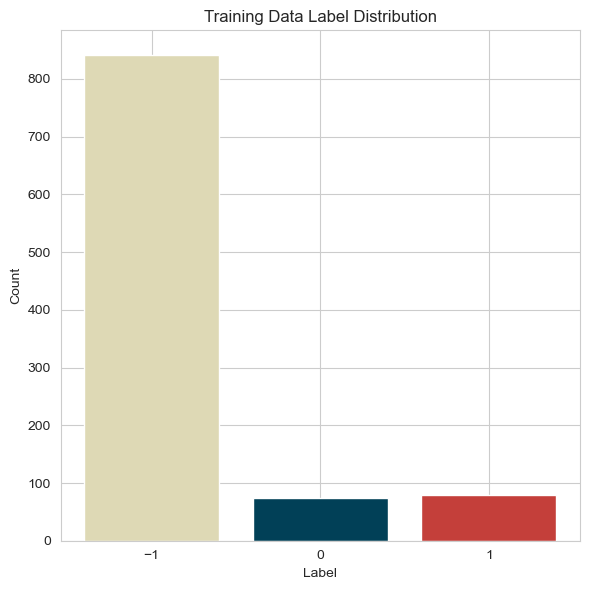

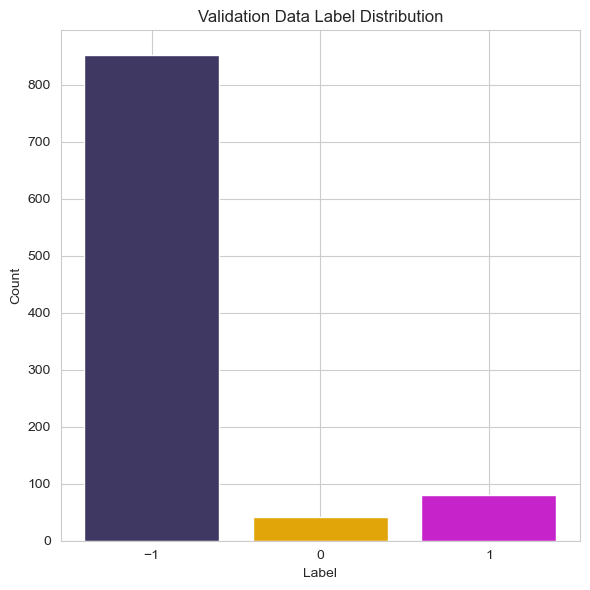

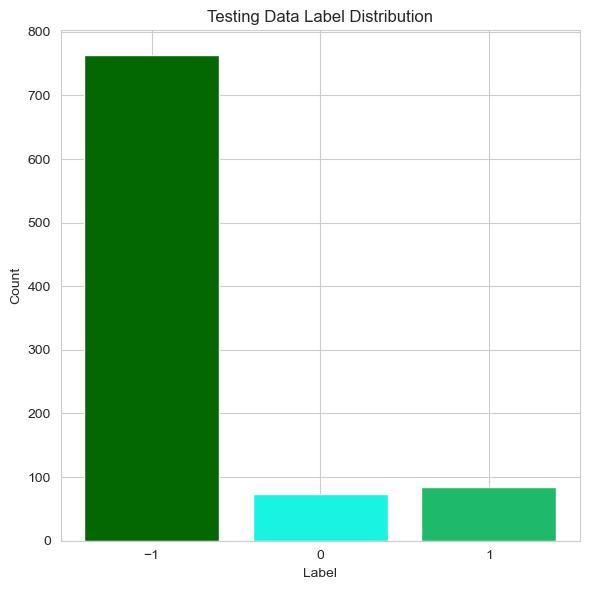

In [69]:
plot_class_imbalance(df_train,'Training', 'Label')
plot_class_imbalance(df_val,'Validation', 'Label')
plot_class_imbalance(df_test,'Testing', 'Label')


Loading the Random Forest Classifier

In [70]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load model
best_rf = joblib.load('../models/RandomForestClassifier_model_sep_cfe.pkl')

Y_pred = best_rf.predict(X_train)

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(Y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(Y_train, Y_pred))


Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       842
           1       0.86      0.82      0.84       154

    accuracy                           0.95       996
   macro avg       0.92      0.90      0.91       996
weighted avg       0.95      0.95      0.95       996

Test Confusion Matrix:
 [[822  20]
 [ 27 127]]


In [71]:
wandb.config.update({
    "model_type": "RandomForestClassifier",
    "model_params": best_rf.get_params()
})


Testing the Model

In [72]:
overall_results = []
overall_results.append(('training set',accuracy_score(Y_train, Y_pred), TSS(Y_train, Y_pred), HSS(Y_train, Y_pred)))
Y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set',accuracy_score(Y_val, Y_val_pred), TSS(Y_val, Y_val_pred), HSS(Y_val, Y_val_pred)))
Y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set',accuracy_score(Y_test, Y_test_pred), TSS(Y_test, Y_test_pred), HSS(Y_test, Y_test_pred)))
pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"])


,Dataset,accuracy,TSS,HSS
0,training set,0.952811,0.800922,0.816077
1,validation set,0.879877,0.423125,0.433895
2,testing set,0.857918,0.381735,0.432794


Loading the CounterFactual Explaner Model: Not used anywhere else down the notebook :p

In [73]:
exp_genetic = joblib.load("../models/sep_cfe_genetic_explainer.pkl")

In [74]:
wandb.config.update({
    "Explainer_model_type": "DiCE_Explainer-Genetic_Method"})

In [75]:
query_instance1 = df_test.drop(["Label","Event_Y_N"],axis=1).iloc[73:74] # should not contain the target column
print("Query Instance for the CFE Generation:\n",query_instance1)
print("Target value for the above query instance\n: ",  df_test.iloc[73]["Event_Y_N"])
print("Predicted value for the above query instance\n: ",best_rf.predict(query_instance1))

Query Instance for the CFE Generation:
     p3_flux_ic_mean@[0:360]  p5_flux_ic_mean@[0:360]  p7_flux_ic_mean@[0:360]  \
73               849.269444                28.320278                 2.765889   

    long_mean@[0:360]  p3_flux_ic_mean@[0:180]  p5_flux_ic_mean@[0:180]  \
73            0.00001               751.766667                24.836667   

    p7_flux_ic_mean@[0:180]  long_mean@[0:180]  p3_flux_ic_mean@[90:270]  \
73                 2.650278           0.000005                752.527778   

    p5_flux_ic_mean@[90:270]  p7_flux_ic_mean@[90:270]  long_mean@[90:270]  \
73                 26.050556                     2.611            0.000006   

    p3_flux_ic_mean@[180:360]  p5_flux_ic_mean@[180:360]  \
73                 946.772222                  31.803889   

    p7_flux_ic_mean@[180:360]  long_mean@[180:360]  p3_flux_ic_mean@[0:90]  \
73                     2.8815             0.000015              806.955556   

    p5_flux_ic_mean@[0:90]  p7_flux_ic_mean@[0:90]  long_m

In [76]:
cfe = exp_genetic.generate_counterfactuals(
    query_instance1,  #multiple query instances can be provided as an input dataframe
    total_CFs=5,  # Number of counterfactual examples to generate
    desired_class=1#'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
)
cfe.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


Query instance (original outcome : 1)


,p3_flux_ic_mean@[0:360],p5_flux_ic_mean@[0:360],p7_flux_ic_mean@[0:360],long_mean@[0:360],p3_flux_ic_mean@[0:180],p5_flux_ic_mean@[0:180],p7_flux_ic_mean@[0:180],long_mean@[0:180],p3_flux_ic_mean@[90:270],p5_flux_ic_mean@[90:270],p7_flux_ic_mean@[90:270],long_mean@[90:270],p3_flux_ic_mean@[180:360],p5_flux_ic_mean@[180:360],p7_flux_ic_mean@[180:360],long_mean@[180:360],p3_flux_ic_mean@[0:90],p5_flux_ic_mean@[0:90],p7_flux_ic_mean@[0:90],long_mean@[0:90],p3_flux_ic_mean@[45:135],p5_flux_ic_mean@[45:135],p7_flux_ic_mean@[45:135],long_mean@[45:135],p3_flux_ic_mean@[90:180],p5_flux_ic_mean@[90:180],p7_flux_ic_mean@[90:180],long_mean@[90:180],p3_flux_ic_mean@[135:225],p5_flux_ic_mean@[135:225],p7_flux_ic_mean@[135:225],long_mean@[135:225],p3_flux_ic_mean@[180:270],p5_flux_ic_mean@[180:270],p7_flux_ic_mean@[180:270],long_mean@[180:270],p3_flux_ic_mean@[225:315],p5_flux_ic_mean@[225:315],p7_flux_ic_mean@[225:315],long_mean@[225:315],p3_flux_ic_mean@[270:360],p5_flux_ic_mean@[270:360],p7_flux_ic_mean@[270:360],long_mean@[270:360],p3_flux_ic_mean@[0:45],p5_flux_ic_mean@[0:45],p7_flux_ic_mean@[0:45],long_mean@[0:45],p3_flux_ic_mean@[23:68],p5_flux_ic_mean@[23:68],p7_flux_ic_mean@[23:68],long_mean@[23:68],p3_flux_ic_mean@[46:91],p5_flux_ic_mean@[46:91],p7_flux_ic_mean@[46:91],long_mean@[46:91],p3_flux_ic_mean@[69:114],p5_flux_ic_mean@[69:114],p7_flux_ic_mean@[69:114],long_mean@[69:114],p3_flux_ic_mean@[92:137],p5_flux_ic_mean@[92:137],p7_flux_ic_mean@[92:137],long_mean@[92:137],p3_flux_ic_mean@[115:160],p5_flux_ic_mean@[115:160],p7_flux_ic_mean@[115:160],long_mean@[115:160],p3_flux_ic_mean@[138:183],p5_flux_ic_mean@[138:183],p7_flux_ic_mean@[138:183],long_mean@[138:183],p3_flux_ic_mean@[161:206],p5_flux_ic_mean@[161:206],p7_flux_ic_mean@[161:206],long_mean@[161:206],p3_flux_ic_mean@[184:229],p5_flux_ic_mean@[184:229],p7_flux_ic_mean@[184:229],long_mean@[184:229],p3_flux_ic_mean@[207:252],p5_flux_ic_mean@[207:252],p7_flux_ic_mean@[207:252],long_mean@[207:252],p3_flux_ic_mean@[230:275],p5_flux_ic_mean@[230:275],p7_flux_ic_mean@[230:275],long_mean@[230:275],p3_flux_ic_mean@[253:298],p5_flux_ic_mean@[253:298],p7_flux_ic_mean@[253:298],long_mean@[253:298],p3_flux_ic_mean@[276:321],p5_flux_ic_mean@[276:321],p7_flux_ic_mean@[276:321],long_mean@[276:321],p3_flux_ic_mean@[299:344],p5_flux_ic_mean@[299:344],p7_flux_ic_mean@[299:344],long_mean@[299:344],p3_flux_ic_mean@[0:23],p5_flux_ic_mean@[0:23],p7_flux_ic_mean@[0:23],long_mean@[0:23],p3_flux_ic_mean@[12:35],p5_flux_ic_mean@[12:35],p7_flux_ic_mean@[12:35],long_mean@[12:35],p3_flux_ic_mean@[24:47],p5_flux_ic_mean@[24:47],p7_flux_ic_mean@[24:47],long_mean@[24:47],p3_flux_ic_mean@[36:59],p5_flux_ic_mean@[36:59],p7_flux_ic_mean@[36:59],long_mean@[36:59],p3_flux_ic_mean@[48:71],p5_flux_ic_mean@[48:71],p7_flux_ic_mean@[48:71],long_mean@[48:71],p3_flux_ic_mean@[60:83],p5_flux_ic_mean@[60:83],p7_flux_ic_mean@[60:83],long_mean@[60:83],p3_flux_ic_mean@[72:95],p5_flux_ic_mean@[72:95],p7_flux_ic_mean@[72:95],long_mean@[72:95],p3_flux_ic_mean@[84:107],p5_flux_ic_mean@[84:107],p7_flux_ic_mean@[84:107],long_mean@[84:107],p3_flux_ic_mean@[96:119],p5_flux_ic_mean@[96:119],p7_flux_ic_mean@[96:119],long_mean@[96:119],p3_flux_ic_mean@[108:131],p5_flux_ic_mean@[108:131],p7_flux_ic_mean@[108:131],long_mean@[108:131],p3_flux_ic_mean@[120:143],p5_flux_ic_mean@[120:143],p7_flux_ic_mean@[120:143],long_mean@[120:143],p3_flux_ic_mean@[132:155],p5_flux_ic_mean@[132:155],p7_flux_ic_mean@[132:155],long_mean@[132:155],p3_flux_ic_mean@[144:167],p5_flux_ic_mean@[144:167],p7_flux_ic_mean@[144:167],long_mean@[144:167],p3_flux_ic_mean@[156:179],p5_flux_ic_mean@[156:179],p7_flux_ic_mean@[156:179],long_mean@[156:179],p3_flux_ic_mean@[168:191],p5_flux_ic_mean@[168:191],p7_flux_ic_mean@[168:191],long_mean@[168:191],p3_flux_ic_mean@[180:203],p5_flux_ic_mean@[180:203],p7_flux_ic_mean@[180:203],long_mean@[180:203],p3_flux_ic_mean@[192:215],p5_flux_ic_mean@[192:215],p7_flux_ic_mean@[192:215],long_mean@[192:215],p3_flux_ic_mean@[204:227],p


Diverse Counterfactual set (new outcome: 1)


,p3_flux_ic_mean@[0:360],p5_flux_ic_mean@[0:360],p7_flux_ic_mean@[0:360],long_mean@[0:360],p3_flux_ic_mean@[0:180],p5_flux_ic_mean@[0:180],p7_flux_ic_mean@[0:180],long_mean@[0:180],p3_flux_ic_mean@[90:270],p5_flux_ic_mean@[90:270],p7_flux_ic_mean@[90:270],long_mean@[90:270],p3_flux_ic_mean@[180:360],p5_flux_ic_mean@[180:360],p7_flux_ic_mean@[180:360],long_mean@[180:360],p3_flux_ic_mean@[0:90],p5_flux_ic_mean@[0:90],p7_flux_ic_mean@[0:90],long_mean@[0:90],p3_flux_ic_mean@[45:135],p5_flux_ic_mean@[45:135],p7_flux_ic_mean@[45:135],long_mean@[45:135],p3_flux_ic_mean@[90:180],p5_flux_ic_mean@[90:180],p7_flux_ic_mean@[90:180],long_mean@[90:180],p3_flux_ic_mean@[135:225],p5_flux_ic_mean@[135:225],p7_flux_ic_mean@[135:225],long_mean@[135:225],p3_flux_ic_mean@[180:270],p5_flux_ic_mean@[180:270],p7_flux_ic_mean@[180:270],long_mean@[180:270],p3_flux_ic_mean@[225:315],p5_flux_ic_mean@[225:315],p7_flux_ic_mean@[225:315],long_mean@[225:315],p3_flux_ic_mean@[270:360],p5_flux_ic_mean@[270:360],p7_flux_ic_mean@[270:360],long_mean@[270:360],p3_flux_ic_mean@[0:45],p5_flux_ic_mean@[0:45],p7_flux_ic_mean@[0:45],long_mean@[0:45],p3_flux_ic_mean@[23:68],p5_flux_ic_mean@[23:68],p7_flux_ic_mean@[23:68],long_mean@[23:68],p3_flux_ic_mean@[46:91],p5_flux_ic_mean@[46:91],p7_flux_ic_mean@[46:91],long_mean@[46:91],p3_flux_ic_mean@[69:114],p5_flux_ic_mean@[69:114],p7_flux_ic_mean@[69:114],long_mean@[69:114],p3_flux_ic_mean@[92:137],p5_flux_ic_mean@[92:137],p7_flux_ic_mean@[92:137],long_mean@[92:137],p3_flux_ic_mean@[115:160],p5_flux_ic_mean@[115:160],p7_flux_ic_mean@[115:160],long_mean@[115:160],p3_flux_ic_mean@[138:183],p5_flux_ic_mean@[138:183],p7_flux_ic_mean@[138:183],long_mean@[138:183],p3_flux_ic_mean@[161:206],p5_flux_ic_mean@[161:206],p7_flux_ic_mean@[161:206],long_mean@[161:206],p3_flux_ic_mean@[184:229],p5_flux_ic_mean@[184:229],p7_flux_ic_mean@[184:229],long_mean@[184:229],p3_flux_ic_mean@[207:252],p5_flux_ic_mean@[207:252],p7_flux_ic_mean@[207:252],long_mean@[207:252],p3_flux_ic_mean@[230:275],p5_flux_ic_mean@[230:275],p7_flux_ic_mean@[230:275],long_mean@[230:275],p3_flux_ic_mean@[253:298],p5_flux_ic_mean@[253:298],p7_flux_ic_mean@[253:298],long_mean@[253:298],p3_flux_ic_mean@[276:321],p5_flux_ic_mean@[276:321],p7_flux_ic_mean@[276:321],long_mean@[276:321],p3_flux_ic_mean@[299:344],p5_flux_ic_mean@[299:344],p7_flux_ic_mean@[299:344],long_mean@[299:344],p3_flux_ic_mean@[0:23],p5_flux_ic_mean@[0:23],p7_flux_ic_mean@[0:23],long_mean@[0:23],p3_flux_ic_mean@[12:35],p5_flux_ic_mean@[12:35],p7_flux_ic_mean@[12:35],long_mean@[12:35],p3_flux_ic_mean@[24:47],p5_flux_ic_mean@[24:47],p7_flux_ic_mean@[24:47],long_mean@[24:47],p3_flux_ic_mean@[36:59],p5_flux_ic_mean@[36:59],p7_flux_ic_mean@[36:59],long_mean@[36:59],p3_flux_ic_mean@[48:71],p5_flux_ic_mean@[48:71],p7_flux_ic_mean@[48:71],long_mean@[48:71],p3_flux_ic_mean@[60:83],p5_flux_ic_mean@[60:83],p7_flux_ic_mean@[60:83],long_mean@[60:83],p3_flux_ic_mean@[72:95],p5_flux_ic_mean@[72:95],p7_flux_ic_mean@[72:95],long_mean@[72:95],p3_flux_ic_mean@[84:107],p5_flux_ic_mean@[84:107],p7_flux_ic_mean@[84:107],long_mean@[84:107],p3_flux_ic_mean@[96:119],p5_flux_ic_mean@[96:119],p7_flux_ic_mean@[96:119],long_mean@[96:119],p3_flux_ic_mean@[108:131],p5_flux_ic_mean@[108:131],p7_flux_ic_mean@[108:131],long_mean@[108:131],p3_flux_ic_mean@[120:143],p5_flux_ic_mean@[120:143],p7_flux_ic_mean@[120:143],long_mean@[120:143],p3_flux_ic_mean@[132:155],p5_flux_ic_mean@[132:155],p7_flux_ic_mean@[132:155],long_mean@[132:155],p3_flux_ic_mean@[144:167],p5_flux_ic_mean@[144:167],p7_flux_ic_mean@[144:167],long_mean@[144:167],p3_flux_ic_mean@[156:179],p5_flux_ic_mean@[156:179],p7_flux_ic_mean@[156:179],long_mean@[156:179],p3_flux_ic_mean@[168:191],p5_flux_ic_mean@[168:191],p7_flux_ic_mean@[168:191],long_mean@[168:191],p3_flux_ic_mean@[180:203],p5_flux_ic_mean@[180:203],p7_flux_ic_mean@[180:203],long_mean@[180:203],p3_flux_ic_mean@[192:215],p5_flux_ic_mean@[192:215],p7_flux_ic_mean@[192:215],long_mean@[192:215],p3_flux_ic_mean@[204:227],p

In [77]:
cfe.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,p3_flux_ic_mean@[0:360],p5_flux_ic_mean@[0:360],p7_flux_ic_mean@[0:360],long_mean@[0:360],p3_flux_ic_mean@[0:180],p5_flux_ic_mean@[0:180],p7_flux_ic_mean@[0:180],long_mean@[0:180],p3_flux_ic_mean@[90:270],p5_flux_ic_mean@[90:270],p7_flux_ic_mean@[90:270],long_mean@[90:270],p3_flux_ic_mean@[180:360],p5_flux_ic_mean@[180:360],p7_flux_ic_mean@[180:360],long_mean@[180:360],p3_flux_ic_mean@[0:90],p5_flux_ic_mean@[0:90],p7_flux_ic_mean@[0:90],long_mean@[0:90],p3_flux_ic_mean@[45:135],p5_flux_ic_mean@[45:135],p7_flux_ic_mean@[45:135],long_mean@[45:135],p3_flux_ic_mean@[90:180],p5_flux_ic_mean@[90:180],p7_flux_ic_mean@[90:180],long_mean@[90:180],p3_flux_ic_mean@[135:225],p5_flux_ic_mean@[135:225],p7_flux_ic_mean@[135:225],long_mean@[135:225],p3_flux_ic_mean@[180:270],p5_flux_ic_mean@[180:270],p7_flux_ic_mean@[180:270],long_mean@[180:270],p3_flux_ic_mean@[225:315],p5_flux_ic_mean@[225:315],p7_flux_ic_mean@[225:315],long_mean@[225:315],p3_flux_ic_mean@[270:360],p5_flux_ic_mean@[270:360],p7_flux_ic_mean@[270:360],long_mean@[270:360],p3_flux_ic_mean@[0:45],p5_flux_ic_mean@[0:45],p7_flux_ic_mean@[0:45],long_mean@[0:45],p3_flux_ic_mean@[23:68],p5_flux_ic_mean@[23:68],p7_flux_ic_mean@[23:68],long_mean@[23:68],p3_flux_ic_mean@[46:91],p5_flux_ic_mean@[46:91],p7_flux_ic_mean@[46:91],long_mean@[46:91],p3_flux_ic_mean@[69:114],p5_flux_ic_mean@[69:114],p7_flux_ic_mean@[69:114],long_mean@[69:114],p3_flux_ic_mean@[92:137],p5_flux_ic_mean@[92:137],p7_flux_ic_mean@[92:137],long_mean@[92:137],p3_flux_ic_mean@[115:160],p5_flux_ic_mean@[115:160],p7_flux_ic_mean@[115:160],long_mean@[115:160],p3_flux_ic_mean@[138:183],p5_flux_ic_mean@[138:183],p7_flux_ic_mean@[138:183],long_mean@[138:183],p3_flux_ic_mean@[161:206],p5_flux_ic_mean@[161:206],p7_flux_ic_mean@[161:206],long_mean@[161:206],p3_flux_ic_mean@[184:229],p5_flux_ic_mean@[184:229],p7_flux_ic_mean@[184:229],long_mean@[184:229],p3_flux_ic_mean@[207:252],p5_flux_ic_mean@[207:252],p7_flux_ic_mean@[207:252],long_mean@[207:252],p3_flux_ic_mean@[230:275],p5_flux_ic_mean@[230:275],p7_flux_ic_mean@[230:275],long_mean@[230:275],p3_flux_ic_mean@[253:298],p5_flux_ic_mean@[253:298],p7_flux_ic_mean@[253:298],long_mean@[253:298],p3_flux_ic_mean@[276:321],p5_flux_ic_mean@[276:321],p7_flux_ic_mean@[276:321],long_mean@[276:321],p3_flux_ic_mean@[299:344],p5_flux_ic_mean@[299:344],p7_flux_ic_mean@[299:344],long_mean@[299:344],p3_flux_ic_mean@[0:23],p5_flux_ic_mean@[0:23],p7_flux_ic_mean@[0:23],long_mean@[0:23],p3_flux_ic_mean@[12:35],p5_flux_ic_mean@[12:35],p7_flux_ic_mean@[12:35],long_mean@[12:35],p3_flux_ic_mean@[24:47],p5_flux_ic_mean@[24:47],p7_flux_ic_mean@[24:47],long_mean@[24:47],p3_flux_ic_mean@[36:59],p5_flux_ic_mean@[36:59],p7_flux_ic_mean@[36:59],long_mean@[36:59],p3_flux_ic_mean@[48:71],p5_flux_ic_mean@[48:71],p7_flux_ic_mean@[48:71],long_mean@[48:71],p3_flux_ic_mean@[60:83],p5_flux_ic_mean@[60:83],p7_flux_ic_mean@[60:83],long_mean@[60:83],p3_flux_ic_mean@[72:95],p5_flux_ic_mean@[72:95],p7_flux_ic_mean@[72:95],long_mean@[72:95],p3_flux_ic_mean@[84:107],p5_flux_ic_mean@[84:107],p7_flux_ic_mean@[84:107],long_mean@[84:107],p3_flux_ic_mean@[96:119],p5_flux_ic_mean@[96:119],p7_flux_ic_mean@[96:119],long_mean@[96:119],p3_flux_ic_mean@[108:131],p5_flux_ic_mean@[108:131],p7_flux_ic_mean@[108:131],long_mean@[108:131],p3_flux_ic_mean@[120:143],p5_flux_ic_mean@[120:143],p7_flux_ic_mean@[120:143],long_mean@[120:143],p3_flux_ic_mean@[132:155],p5_flux_ic_mean@[132:155],p7_flux_ic_mean@[132:155],long_mean@[132:155],p3_flux_ic_mean@[144:167],p5_flux_ic_mean@[144:167],p7_flux_ic_mean@[144:167],long_mean@[144:167],p3_flux_ic_mean@[156:179],p5_flux_ic_mean@[156:179],p7_flux_ic_mean@[156:179],long_mean@[156:179],p3_flux_ic_mean@[168:191],p5_flux_ic_mean@[168:191],p7_flux_ic_mean@[168:191],long_mean@[168:191],p3_flux_ic_mean@[180:203],p5_flux_ic_mean@[180:203],p7_flux_ic_mean@[180:203],long_mean@[180:203],p3_flux_ic_mean@[192:215],p5_flux_ic_mean@[192:215],p7_flux_ic_mean@[192:215],long_mean@[192:215],p3_flux_ic_mean@[204:227],p


Diverse Counterfactual set (new outcome: 1)


,p3_flux_ic_mean@[0:360],p5_flux_ic_mean@[0:360],p7_flux_ic_mean@[0:360],long_mean@[0:360],p3_flux_ic_mean@[0:180],p5_flux_ic_mean@[0:180],p7_flux_ic_mean@[0:180],long_mean@[0:180],p3_flux_ic_mean@[90:270],p5_flux_ic_mean@[90:270],p7_flux_ic_mean@[90:270],long_mean@[90:270],p3_flux_ic_mean@[180:360],p5_flux_ic_mean@[180:360],p7_flux_ic_mean@[180:360],long_mean@[180:360],p3_flux_ic_mean@[0:90],p5_flux_ic_mean@[0:90],p7_flux_ic_mean@[0:90],long_mean@[0:90],p3_flux_ic_mean@[45:135],p5_flux_ic_mean@[45:135],p7_flux_ic_mean@[45:135],long_mean@[45:135],p3_flux_ic_mean@[90:180],p5_flux_ic_mean@[90:180],p7_flux_ic_mean@[90:180],long_mean@[90:180],p3_flux_ic_mean@[135:225],p5_flux_ic_mean@[135:225],p7_flux_ic_mean@[135:225],long_mean@[135:225],p3_flux_ic_mean@[180:270],p5_flux_ic_mean@[180:270],p7_flux_ic_mean@[180:270],long_mean@[180:270],p3_flux_ic_mean@[225:315],p5_flux_ic_mean@[225:315],p7_flux_ic_mean@[225:315],long_mean@[225:315],p3_flux_ic_mean@[270:360],p5_flux_ic_mean@[270:360],p7_flux_ic_mean@[270:360],long_mean@[270:360],p3_flux_ic_mean@[0:45],p5_flux_ic_mean@[0:45],p7_flux_ic_mean@[0:45],long_mean@[0:45],p3_flux_ic_mean@[23:68],p5_flux_ic_mean@[23:68],p7_flux_ic_mean@[23:68],long_mean@[23:68],p3_flux_ic_mean@[46:91],p5_flux_ic_mean@[46:91],p7_flux_ic_mean@[46:91],long_mean@[46:91],p3_flux_ic_mean@[69:114],p5_flux_ic_mean@[69:114],p7_flux_ic_mean@[69:114],long_mean@[69:114],p3_flux_ic_mean@[92:137],p5_flux_ic_mean@[92:137],p7_flux_ic_mean@[92:137],long_mean@[92:137],p3_flux_ic_mean@[115:160],p5_flux_ic_mean@[115:160],p7_flux_ic_mean@[115:160],long_mean@[115:160],p3_flux_ic_mean@[138:183],p5_flux_ic_mean@[138:183],p7_flux_ic_mean@[138:183],long_mean@[138:183],p3_flux_ic_mean@[161:206],p5_flux_ic_mean@[161:206],p7_flux_ic_mean@[161:206],long_mean@[161:206],p3_flux_ic_mean@[184:229],p5_flux_ic_mean@[184:229],p7_flux_ic_mean@[184:229],long_mean@[184:229],p3_flux_ic_mean@[207:252],p5_flux_ic_mean@[207:252],p7_flux_ic_mean@[207:252],long_mean@[207:252],p3_flux_ic_mean@[230:275],p5_flux_ic_mean@[230:275],p7_flux_ic_mean@[230:275],long_mean@[230:275],p3_flux_ic_mean@[253:298],p5_flux_ic_mean@[253:298],p7_flux_ic_mean@[253:298],long_mean@[253:298],p3_flux_ic_mean@[276:321],p5_flux_ic_mean@[276:321],p7_flux_ic_mean@[276:321],long_mean@[276:321],p3_flux_ic_mean@[299:344],p5_flux_ic_mean@[299:344],p7_flux_ic_mean@[299:344],long_mean@[299:344],p3_flux_ic_mean@[0:23],p5_flux_ic_mean@[0:23],p7_flux_ic_mean@[0:23],long_mean@[0:23],p3_flux_ic_mean@[12:35],p5_flux_ic_mean@[12:35],p7_flux_ic_mean@[12:35],long_mean@[12:35],p3_flux_ic_mean@[24:47],p5_flux_ic_mean@[24:47],p7_flux_ic_mean@[24:47],long_mean@[24:47],p3_flux_ic_mean@[36:59],p5_flux_ic_mean@[36:59],p7_flux_ic_mean@[36:59],long_mean@[36:59],p3_flux_ic_mean@[48:71],p5_flux_ic_mean@[48:71],p7_flux_ic_mean@[48:71],long_mean@[48:71],p3_flux_ic_mean@[60:83],p5_flux_ic_mean@[60:83],p7_flux_ic_mean@[60:83],long_mean@[60:83],p3_flux_ic_mean@[72:95],p5_flux_ic_mean@[72:95],p7_flux_ic_mean@[72:95],long_mean@[72:95],p3_flux_ic_mean@[84:107],p5_flux_ic_mean@[84:107],p7_flux_ic_mean@[84:107],long_mean@[84:107],p3_flux_ic_mean@[96:119],p5_flux_ic_mean@[96:119],p7_flux_ic_mean@[96:119],long_mean@[96:119],p3_flux_ic_mean@[108:131],p5_flux_ic_mean@[108:131],p7_flux_ic_mean@[108:131],long_mean@[108:131],p3_flux_ic_mean@[120:143],p5_flux_ic_mean@[120:143],p7_flux_ic_mean@[120:143],long_mean@[120:143],p3_flux_ic_mean@[132:155],p5_flux_ic_mean@[132:155],p7_flux_ic_mean@[132:155],long_mean@[132:155],p3_flux_ic_mean@[144:167],p5_flux_ic_mean@[144:167],p7_flux_ic_mean@[144:167],long_mean@[144:167],p3_flux_ic_mean@[156:179],p5_flux_ic_mean@[156:179],p7_flux_ic_mean@[156:179],long_mean@[156:179],p3_flux_ic_mean@[168:191],p5_flux_ic_mean@[168:191],p7_flux_ic_mean@[168:191],long_mean@[168:191],p3_flux_ic_mean@[180:203],p5_flux_ic_mean@[180:203],p7_flux_ic_mean@[180:203],long_mean@[180:203],p3_flux_ic_mean@[192:215],p5_flux_ic_mean@[192:215],p7_flux_ic_mean@[192:215],long_mean@[192:215],p3_flux_ic_mean@[204:227],p

In [78]:

wandb.log({
    "Query_Instance": wandb.Table(dataframe=query_instance1),
    "True_Label": df_test.iloc[73]["Event_Y_N"],
    "Predicted_Label": int(best_rf.predict(query_instance1)[0])
})
# Get CF dataframe (only showing changes)
cf_df =  cfe.cf_examples_list[0].final_cfs_df

# Optional: Add query instance to this DataFrame to compare
cf_df["Original_Index"] = 73  # Tag the original index
wandb.log({"Counterfactuals": wandb.Table(dataframe=cf_df)})


Feature Importance

                       Feature  Importance
912  p3_flux_ic_mean@[345:351]    0.016813
412  p3_flux_ic_mean@[294:306]    0.015512
12   p3_flux_ic_mean@[180:360]    0.013846
900  p3_flux_ic_mean@[336:342]    0.013482
212  p3_flux_ic_mean@[336:359]    0.011833
860  p3_flux_ic_mean@[306:312]    0.011426
440  p3_flux_ic_mean@[336:348]    0.010817
924  p3_flux_ic_mean@[354:360]    0.010343
200  p3_flux_ic_mean@[300:323]    0.009730
435        long_mean@[324:336]    0.009371
211        long_mean@[324:347]    0.009296
908  p3_flux_ic_mean@[342:348]    0.009174
920  p3_flux_ic_mean@[351:357]    0.009126
352  p3_flux_ic_mean@[204:216]    0.009033
208  p3_flux_ic_mean@[324:347]    0.008997
888  p3_flux_ic_mean@[327:333]    0.008828
448  p3_flux_ic_mean@[348:360]    0.008497
420  p3_flux_ic_mean@[306:318]    0.007659
884  p3_flux_ic_mean@[324:330]    0.007371
168  p3_flux_ic_mean@[204:227]    0.007342


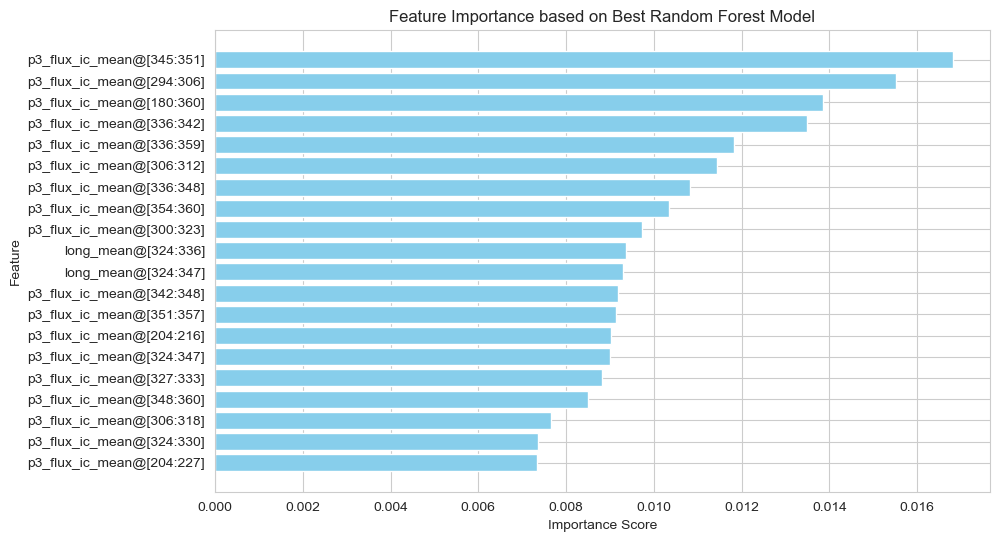

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `best_rf` is your trained Random Forest model
# and `X_train` contains the feature names

# Get feature importance scores
feature_importances = best_rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
wandb.log({"top20_feature_importances": wandb.Table(data=feature_importance_df, columns=["feature", "importance"])})
# Display the top features
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


Visualization

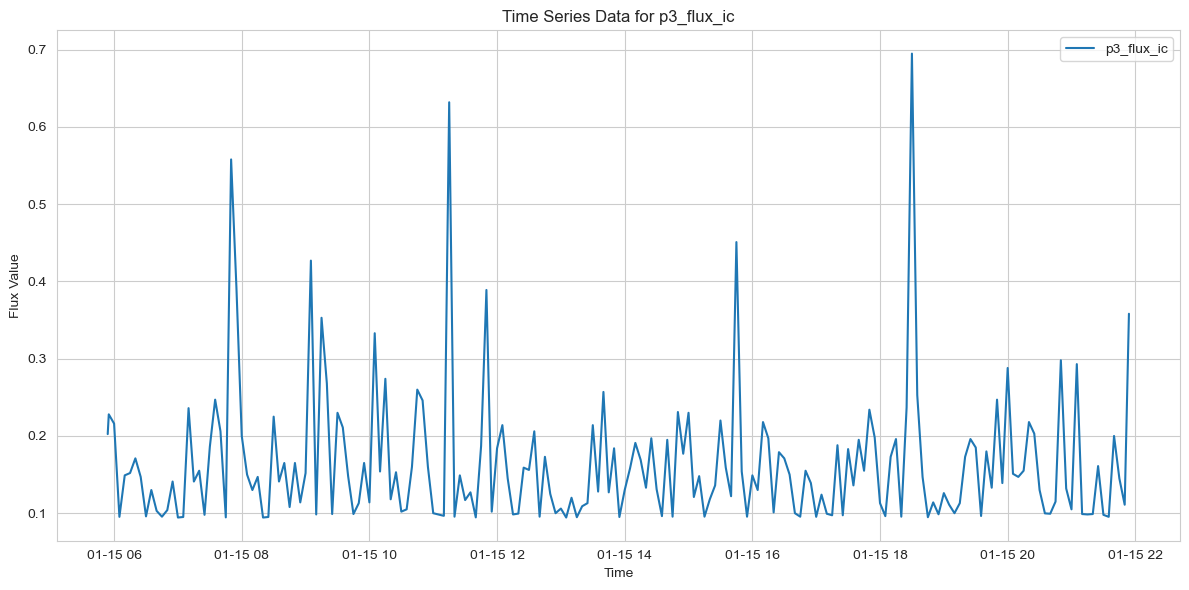

<Figure size 640x480 with 0 Axes>

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Read the CSV file (adjust the delimiter if needed)
df = pd.read_csv('../data/raw/data/1986-01-15_05-54.csv', delimiter=',')

# Convert the 'time_stamp' column to datetime objects.
# Adjust the format if your timestamp format is different.
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

# Set the event start time as the first timestamp in the file.
event_start = df['time_stamp'].iloc[0]

# Create a column for elapsed time in minutes relative to the event start.
df['minutes'] = (df['time_stamp'] - event_start).dt.total_seconds() / 60

# Plot the timeseries data for the chosen parameters.
plt.figure(figsize=(12, 6))
plt.plot(df['time_stamp'], df['p3_flux_ic'], label='p3_flux_ic',  markersize=3)
#plt.plot(df['time_stamp'], df['p5_flux_ic'], label='p5_flux_ic', marker='s', markersize=3)
#plt.plot(df['time_stamp'], df['p7_flux_ic'], label='p7_flux_ic', marker='^', markersize=3)

# Define time slices (in minutes) for which you want to calculate the mean.
# Here we use two slices as an example: 0-180 minutes and 180-360 minutes.
slices = [(0, 180), (180, 360)]
slice_colors = ['red', 'green']

for (i, (start_min, end_min)) in enumerate(slices):
    # Filter the data that falls within the current slice.
    slice_data = df[(df['minutes'] >= start_min) & (df['minutes'] < end_min)]

    if slice_data.empty:
        continue  # Skip if there is no data in this slice.

    # Compute the corresponding datetime boundaries for the slice.
    slice_start_time = event_start + timedelta(minutes=start_min)
    slice_end_time = event_start + timedelta(minutes=end_min)


# Format the plot.
plt.xlabel('Time')
plt.ylabel('Flux Value')
plt.title('Time Series Data for p3_flux_ic')
plt.legend()
plt.tight_layout()
plt.show()
wandb.log({f"Time Series SEP_1986-01-15_05-54.csv Data for p3_flux_ic": wandb.Image(plt)})

Overlaying Mean valued data on Timeseries

In [81]:
import re
def process_header_list(header_list):
    """
    Given a list of column names (e.g. from df.columns.to_list()),
    extract columns matching the pattern:
       <metric>@[<start>:<end>]
    where <metric> is one of: p3_flux_ic_mean, p5_flux_ic_mean, p7_flux_ic_mean, long_mean.

    Returns a list of tuples:
         (metric, slice_str, start, end)
    """
    pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)@\[(\d+:\d+)\]$'
    result = []
    for col in header_list:
        m = re.match(pattern, col)
        if m:
            metric = m.group(1)
            slice_str = m.group(2)
            start, end = map(int, slice_str.split(':'))
            result.append((metric, slice_str, start, end))
    return result

header_list = df_train.columns.astype(str).str.cat(sep="\t").split()
# Process the header list to extract (metric, slice, start, end)
entries = process_header_list(header_list)
# Group entries by metric.
groups = {}
for metric, slice_str, start, end in entries:
    groups.setdefault(metric, []).append((slice_str, start, end))
# Sort each group by slice start and then end.
for metric in groups:
    groups[metric] = sorted(groups[metric], key=lambda x: (x[1], x[2]))
df_slices = pd.DataFrame(groups)
print(df_slices)



         p3_flux_ic_mean      p5_flux_ic_mean      p7_flux_ic_mean  \
0            (0:6, 0, 6)          (0:6, 0, 6)          (0:6, 0, 6)   
1          (0:12, 0, 12)        (0:12, 0, 12)        (0:12, 0, 12)   
2          (0:23, 0, 23)        (0:23, 0, 23)        (0:23, 0, 23)   
3          (0:45, 0, 45)        (0:45, 0, 45)        (0:45, 0, 45)   
4          (0:90, 0, 90)        (0:90, 0, 90)        (0:90, 0, 90)   
5        (0:180, 0, 180)      (0:180, 0, 180)      (0:180, 0, 180)   
6        (0:360, 0, 360)      (0:360, 0, 360)      (0:360, 0, 360)   
7            (3:9, 3, 9)          (3:9, 3, 9)          (3:9, 3, 9)   
8          (6:12, 6, 12)        (6:12, 6, 12)        (6:12, 6, 12)   
9          (6:18, 6, 18)        (6:18, 6, 18)        (6:18, 6, 18)   
10         (9:15, 9, 15)        (9:15, 9, 15)        (9:15, 9, 15)   
11       (12:18, 12, 18)      (12:18, 12, 18)      (12:18, 12, 18)   
12       (12:24, 12, 24)      (12:24, 12, 24)      (12:24, 12, 24)   
13       (12:35, 12,

In [82]:
def extract_values(column_name):
    extracted_list = []
    for cell in df_slices[column_name]:
        extracted_list.append((cell[1], cell[2]))  # Extract 2nd and 3rd values
    return extracted_list

# Extracting for a specific column
result = extract_values("p3_flux_ic_mean")
print(result)

[(0, 6), (0, 12), (0, 23), (0, 45), (0, 90), (0, 180), (0, 360), (3, 9), (6, 12), (6, 18), (9, 15), (12, 18), (12, 24), (12, 35), (15, 21), (18, 24), (18, 30), (21, 27), (23, 68), (24, 30), (24, 36), (24, 47), (27, 33), (30, 36), (30, 42), (33, 39), (36, 42), (36, 48), (36, 59), (39, 45), (42, 48), (42, 54), (45, 51), (45, 135), (46, 91), (48, 54), (48, 60), (48, 71), (51, 57), (54, 60), (54, 66), (57, 63), (60, 66), (60, 72), (60, 83), (63, 69), (66, 72), (66, 78), (69, 75), (69, 114), (72, 78), (72, 84), (72, 95), (75, 81), (78, 84), (78, 90), (81, 87), (84, 90), (84, 96), (84, 107), (87, 93), (90, 96), (90, 102), (90, 180), (90, 270), (92, 137), (93, 99), (96, 102), (96, 108), (96, 119), (99, 105), (102, 108), (102, 114), (105, 111), (108, 114), (108, 120), (108, 131), (111, 117), (114, 120), (114, 126), (115, 160), (117, 123), (120, 126), (120, 132), (120, 143), (123, 129), (126, 132), (126, 138), (129, 135), (132, 138), (132, 144), (132, 155), (135, 141), (135, 225), (138, 144), (

### Visualization ###

In [83]:
df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']
# print(df_multi_labels)
# print(df_combined)
df_combined_labels= pd.concat([df_combined,df_multi_labels], axis=1)
df_combined_labels.describe()

p3_flux_ic_mean@[0:360]  p5_flux_ic_mean@[0:360]  \
count              2892.000000              2892.000000   
mean                  1.837355                 0.173353   
std                  22.592907                 1.814121   
min                   0.058025                 0.019561   
25%                   0.128567                 0.053078   
50%                   0.158023                 0.062342   
75%                   0.285771                 0.081891   
max                 849.269444                79.841520   

       p7_flux_ic_mean@[0:360]  long_mean@[0:360]  p3_flux_ic_mean@[0:180]  \
count              2892.000000        2892.000000              2892.000000   
mean                  0.051584           4.935623                 1.861258   
std                   0.219499         206.138971                22.409968   
min                   0.010158           0.000000                 0.053690   
25%                   0.027340           0.000001                 0.127350   
50%                   0.032040           0.000002                 0.156631   
75%                   0.039931           0.000004                 0.251113   
max                   6.974571       10380.952382               751.766667   

       p5_flux_ic_mean@[0:180]  p7_flux_ic_mean@[0:180]  long_mean@[0:180]  \
count              2892.000000              2892.000000        2892.000000   
mean                  0.202577                 0.053538           0.000004   
std                   3.165399                 0.321801           0.000014   
min                   0.019358                 0.009112           0.000000   
25%                   0.052567                 0.026893           0.000001   
50%                   0.061872                 0.031877           0.000002   
75%                   0.079907                 0.039736           0.000003   
max                 159.562275                13.933555           0.000463   

       p3_flux_ic_mean@[90:270]  p5_flux_ic_mean@[90:270]  \
count               2892.000000               2892.000000   
mean                   1.770139                  0.165894   
std                   21.110892                  1.517961   
min                    0.054680                  0.018737   
25%                    0.127218                  0.052520   
50%                    0.158374                  0.061832   
75%                    0.261998                  0.080884   
max                  752.527778                 57.785003   

       p7_flux_ic_mean@[90:270]  long_mean@[90:270]  \
count               2892.000000         2892.000000   
mean                   0.052373            2.961375   
std                    0.307178          159.254606   
min                    0.010158            0.000000   
25%                    0.026896            0.000001   
50%                    0.031918            0.000002   
75%                    0.039956            0.000003   
max                   13.932884         8564.285716   

       p3_flux_ic_mean@[180:360]  p5_flux_ic_mean@[180:360]  \
count                2892.000000                2892.000000   
mean                    1.813452                   0.144129   
std                    23.160415                   1.039341   
min                     0.053861                   0.019258   
25%                     0.127420                   0.052502   
50%                     0.158546                   0.062336   
75%                     0.281653                   0.083233   
max                   946.772222                  36.768889   

       p7_flux_ic_mean@[180:360]  long_mean@[180:360]  p3_flux_ic_mean@[0:90]  \
count                2892.000000          2892.000000             2892.000000   
mean                    0.049630             9.871242                1.920150   
std                     0.187910           412.277942               24.026122   
min                     0.010832             0.000000                0.049050   
25%                     0.026921             0.000

Event Start Time : 1986-01-15 10:54:00
Event End Time : 1986-01-15 16:54:00
             time_stamp  e2_flux_ic  p2_flux_ic  p3_flux_ic  p4_flux_ic  \
300 1986-01-15 10:54:00       967.0      0.2844     0.17720     0.11016   
301 1986-01-15 10:55:00       971.0      0.1850     0.16000     0.11700   
302 1986-01-15 10:56:00      1010.8      0.1880     0.14800     0.10440   
303 1986-01-15 10:57:00      1050.6      0.1910     0.13600     0.09180   
304 1986-01-15 10:58:00      1090.4      0.1940     0.12400     0.07920   
305 1986-01-15 10:59:00      1130.2      0.1970     0.11200     0.06660   
306 1986-01-15 11:00:00      1170.0      0.2000     0.10000     0.05400   
307 1986-01-15 11:01:00      1188.0      0.2212     0.09964     0.05368   
308 1986-01-15 11:02:00      1206.0      0.2424     0.09928     0.05336   
309 1986-01-15 11:03:00      1224.0      0.2636     0.09892     0.05304   
310 1986-01-15 11:04:00      1242.0      0.2848     0.09856     0.05272   
311 1986-01-15 11:05:00 

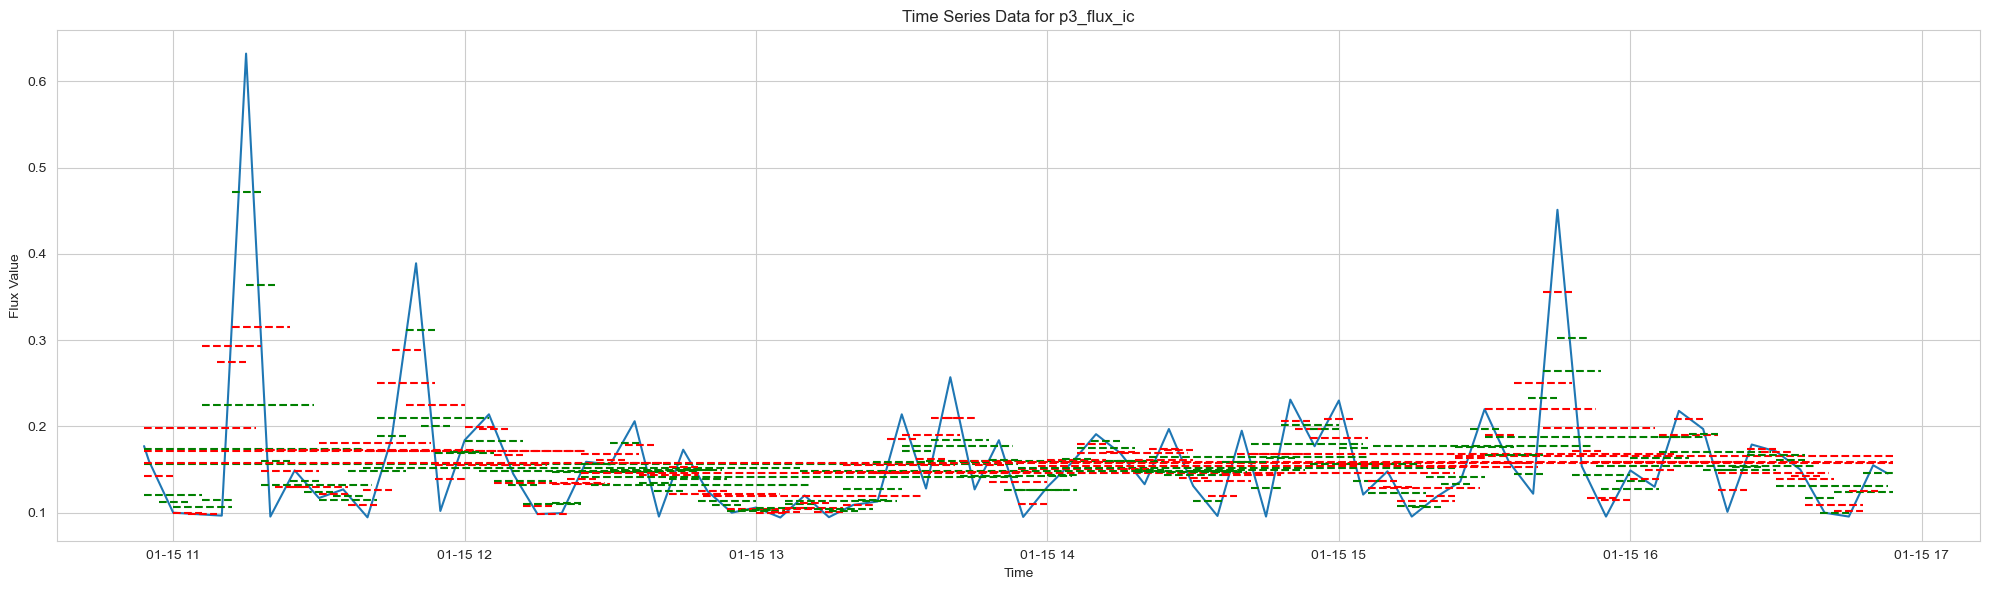

<Figure size 640x480 with 0 Axes>

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

filename = '1986-01-15_05-54.csv'
# Read the CSV file (adjust the delimiter if needed)
df = pd.read_csv('../data/raw/data/'+filename, delimiter=',')

# Convert the 'time_stamp' column to datetime objects.
# Adjust the format if your timestamp format is different.
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

# Set the event start time as the first timestamp in the file.
obs_event_start = df['time_stamp'].iloc[0] + timedelta(minutes=300)
obs_event_end = df['time_stamp'].iloc[0] + timedelta(minutes=660)

print(f"Event Start Time : {obs_event_start}")
print(f"Event End Time : {obs_event_end}")

df_obs = df[(df['time_stamp'] >= obs_event_start) & (df['time_stamp'] < obs_event_end)].copy()

# Create a column for elapsed time in minutes relative to the event start.
df_obs['minutes'] = (df_obs['time_stamp'] - obs_event_start).dt.total_seconds() / 60

print(df_obs)


# Plot the timeseries data for the chosen parameters.
plt.figure(figsize=(20, 6))
plt.plot(df_obs['time_stamp'], df_obs['p3_flux_ic'], label='p3_flux_ic',  markersize=3)
# plt.plot(df_obs['time_stamp'], df_obs['p5_flux_ic'], label='p5_flux_ic',  markersize=3)
# plt.plot(df_obs['time_stamp'], df_obs['p7_flux_ic'], label='p7_flux_ic',  markersize=3)

# Define time slices (in minutes) for which you want to calculate the mean.
slices = result  # Extracted from the previous cell
slice_colors = ['red', 'green']

for (i, (start_min, end_min)) in enumerate(slices):
    print(f"Processing slice {i}: {start_min} - {end_min}")
    print(obs_event_start)
    # Filter the data that falls within the current slice.
    slice_data = df_obs[(df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)]

    if slice_data.empty:
        continue  # Skip if there is no data in this slice.

    # Calculate means for the parameters. Here we calculate for p3_flux_ic.
    # mean_p3 = slice_data['p3_flux_ic'].mean()
    filtered_df=df_combined_labels[df_combined_labels['File']==filename]
    pattern = r'^p3_flux_ic_mean@' + r'\[' + str(start_min) + r':' + str(end_min) + r'\]$'
    mean_p3 = filtered_df.filter(regex=pattern, axis=1).iloc[0]

    # Compute the corresponding datetime boundaries for the slice.
    slice_start_time = obs_event_start + timedelta(minutes=start_min)
    slice_end_time = obs_event_start + timedelta(minutes=end_min)

    # Draw a horizontal dashed line representing the mean in this slice.
    plt.hlines(mean_p3, slice_start_time, slice_end_time,
               colors=slice_colors[i%2],
               linestyles='dashed',
               label=f'p3_flux_ic mean [{start_min}:{end_min}]')

    # Optionally, mark the boundaries of the slice with vertical lines.
    # plt.axvline(slice_start_time, color=slice_colors[i%2], linestyle=':', alpha=0.7)
    # plt.axvline(slice_end_time, color=slice_colors[i%2], linestyle=':', alpha=0.7)

# Format the plot.
plt.xlabel('Time')
plt.ylabel('Flux Value')
plt.title('Time Series Data for p3_flux_ic')
#plt.legend()
plt.tight_layout()
plt.show()
wandb.log({f"Time Series SEP_1986-01-15_05-54.csv Data for p3_flux_ic overlayed with Mean Values": wandb.Image(plt)})

In [85]:
import plotly.graph_objects as go

filename = '1986-01-15_05-54.csv'
# Read the CSV file (adjust the delimiter if needed)
df = pd.read_csv('../data/raw/data/'+filename, delimiter=',')

# Convert the 'time_stamp' column to datetime objects.
# Adjust the format if your timestamp format is different.
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

# Set the event start time as the first timestamp in the file.
obs_event_start = df['time_stamp'].iloc[0] + timedelta(minutes=300)
obs_event_end = df['time_stamp'].iloc[0] + timedelta(minutes=660)

print(f"Event Start Time : {obs_event_start}")
print(f"Event End Time : {obs_event_end}")

df_obs = df[(df['time_stamp'] >= obs_event_start) & (df['time_stamp'] < obs_event_end)].copy()

# Create a column for elapsed time in minutes relative to the event start.
df_obs['minutes'] = (df_obs['time_stamp'] - obs_event_start).dt.total_seconds() / 60

print(df_obs)


# Create a plotly figure
fig = go.Figure()

# Add the main time series line
fig.add_trace(go.Scatter(
    x=df_obs['time_stamp'],
    y=df_obs['p3_flux_ic'],
    mode='lines',
    name="p3_flux_ic"
))
# print(df_obs['minutes'])
slices = result
for i, (start_min, end_min) in enumerate(slices):
    print(f"Processing slice {i}: {start_min} - {end_min}")

    slice_data = df_obs[(df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)]
    if slice_data.empty:
        continue

    # mean_p3 = slice_data['p3_flux_ic'].mean()
    filtered_df=df_combined_labels[df_combined_labels['File']==filename]
    pattern = r'^p3_flux_ic_mean@' + r'\[' + str(start_min) + r':' + str(end_min) + r'\]$'
    mean_p3 = filtered_df.filter(regex=pattern, axis=1).iloc[0].values[0]

    slice_start_time = obs_event_start + timedelta(minutes=start_min)
    slice_end_time = obs_event_start + timedelta(minutes=end_min)

    # Add horizontal dashed line for the mean in the slice
    fig.add_trace(go.Scatter(
        x=[slice_start_time, slice_end_time],
        y=[mean_p3, mean_p3],
        mode='lines',
        line=dict(color="#A9D18E", width=2),
        name=f"Mean [{start_min}-{end_min}]",
        hoverinfo="text",
        text=[f"Mean: {mean_p3:.3f}"] * 2,  # Show mean value only when hovering
    ))


# Update layout for better display
fig.update_layout(
    title="Interactive Time Series for p3_flux_ic",
    xaxis_title="Time",
    yaxis_title="Flux Value",
    xaxis=dict(
        tickformat="%Y-%m-%d %H:%M",
        rangeslider=dict(visible=True),  # Adds zoom slider
    ),
    template="plotly_white"
)

# Show the interactive plot
fig.show()
wandb.log({f"Interactive Time Series SEP_1986-01-15_05-54.csv Data for p3_flux_ic overlayed with Mean Values": fig})

Event Start Time : 1986-01-15 10:54:00
Event End Time : 1986-01-15 16:54:00
             time_stamp  e2_flux_ic  p2_flux_ic  p3_flux_ic  p4_flux_ic  \
300 1986-01-15 10:54:00       967.0      0.2844     0.17720     0.11016   
301 1986-01-15 10:55:00       971.0      0.1850     0.16000     0.11700   
302 1986-01-15 10:56:00      1010.8      0.1880     0.14800     0.10440   
303 1986-01-15 10:57:00      1050.6      0.1910     0.13600     0.09180   
304 1986-01-15 10:58:00      1090.4      0.1940     0.12400     0.07920   
305 1986-01-15 10:59:00      1130.2      0.1970     0.11200     0.06660   
306 1986-01-15 11:00:00      1170.0      0.2000     0.10000     0.05400   
307 1986-01-15 11:01:00      1188.0      0.2212     0.09964     0.05368   
308 1986-01-15 11:02:00      1206.0      0.2424     0.09928     0.05336   
309 1986-01-15 11:03:00      1224.0      0.2636     0.09892     0.05304   
310 1986-01-15 11:04:00      1242.0      0.2848     0.09856     0.05272   
311 1986-01-15 11:05:00 

In [86]:
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose

# df_obs.set_index('time_stamp', inplace=True)  # Set as index

print(df_obs)


# Perform decomposition (adjust period based on data frequency)
decomp_result = seasonal_decompose(df_obs['p3_flux_ic'], model='additive', period=60)

# Create Plotly figure
fig = go.Figure()

# Observed Component
fig.add_trace(go.Scatter(x=df_obs.index, y=decomp_result.observed, mode='lines', name='Observed', line=dict(color='blue')))

# Trend Component
fig.add_trace(go.Scatter(x=df_obs.index, y=decomp_result.trend, mode='lines', name='Trend', line=dict(color='red')))

# Seasonality Component
fig.add_trace(go.Scatter(x=df_obs.index, y=decomp_result.seasonal, mode='lines', name='Seasonality', line=dict(color='green')))

# Residual Component
fig.add_trace(go.Scatter(x=df_obs.index, y=decomp_result.resid, mode='lines', name='Residual', line=dict(color='purple', dash='dot')))

# Layout customization
fig.update_layout(title="Time Series Decomposition of p3_flux_ic",
                  xaxis_title="Time",
                  yaxis_title="Flux Value",
                  template="plotly_white",
                  hovermode="x unified")

fig.show()
wandb.log({f"Time Series SEP_1986-01-15_05-54.csv Decomposition of p3_flux_ic": fig})


             time_stamp  e2_flux_ic  p2_flux_ic  p3_flux_ic  p4_flux_ic  \
300 1986-01-15 10:54:00       967.0      0.2844     0.17720     0.11016   
301 1986-01-15 10:55:00       971.0      0.1850     0.16000     0.11700   
302 1986-01-15 10:56:00      1010.8      0.1880     0.14800     0.10440   
303 1986-01-15 10:57:00      1050.6      0.1910     0.13600     0.09180   
304 1986-01-15 10:58:00      1090.4      0.1940     0.12400     0.07920   
305 1986-01-15 10:59:00      1130.2      0.1970     0.11200     0.06660   
306 1986-01-15 11:00:00      1170.0      0.2000     0.10000     0.05400   
307 1986-01-15 11:01:00      1188.0      0.2212     0.09964     0.05368   
308 1986-01-15 11:02:00      1206.0      0.2424     0.09928     0.05336   
309 1986-01-15 11:03:00      1224.0      0.2636     0.09892     0.05304   
310 1986-01-15 11:04:00      1242.0      0.2848     0.09856     0.05272   
311 1986-01-15 11:05:00      1260.0      0.3060     0.09820     0.05240   
312 1986-01-15 11:06:00  

In [87]:
import plotly.express as px

# Basic Boxplot for Entire Time Series
fig = px.box(df_obs,
             x=df_obs['time_stamp'].dt.hour,  # Group by hour of the day
             y="p3_flux_ic",
             title="Boxplot of p3_flux_ic Over Time",
             labels={"x": "Hour of the Day", "y": "Flux Value"},
             points="all")  # Show all outliers as individual points

fig.update_layout(template="plotly_dark")  # Dark theme for better contrast
fig.show()


Visualization of dummy pertubed series along with an original timeseries

In [88]:
import numpy as np
import pandas as pd
from datetime import timedelta
import plotly.graph_objects as go
import re

# --- Data Preparation ---
filename = '1986-01-15_05-54.csv'
df = pd.read_csv('../data/raw/data/' + filename, delimiter=',')
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

# Define event times (adjust as needed)
obs_event_start = df['time_stamp'].iloc[0] + timedelta(minutes=300)
obs_event_end = df['time_stamp'].iloc[0] + timedelta(minutes=660)
df_obs = df[(df['time_stamp'] >= obs_event_start) & (df['time_stamp'] < obs_event_end)].copy()
df_obs['minutes'] = (df_obs['time_stamp'] - obs_event_start).dt.total_seconds() / 60

# Assume df_obs['p3_flux_ic'] is your original series.
original = df_obs['p3_flux_ic'].values
minutes = df_obs['minutes'].values

# --- Define the Sliding Windows and Their Target Means ---
# 'slices' is a list of tuples (start_min, end_min)
slices = [(0, 6), (0, 12), (0, 23), (0, 45), (0, 90), (0, 180), (0, 360),
          (3, 9), (6, 12), (6, 18), (9, 15), (12, 18), (12, 24), (12, 35),
          (15, 21), (18, 24), (18, 30), (21, 27), (23, 68), (24, 30),
          (24, 36), (24, 47), (27, 33), (30, 36), (30, 42), (33, 39),
          (36, 42), (36, 48), (36, 59), (39, 45), (42, 48), (42, 54),
          (45, 51), (45, 135), (46, 91), (48, 54), (48, 60), (48, 71),
          (51, 57), (54, 60), (54, 66), (57, 63), (60, 66), (60, 72),
          (60, 83), (63, 69), (66, 72), (66, 78), (69, 75), (69, 114),
          (72, 78), (72, 84), (72, 95), (75, 81), (78, 84), (78, 90),
          (81, 87), (84, 90), (84, 96), (84, 107), (87, 93), (90, 96),
          (90, 102), (90, 180), (90, 270), (92, 137), (93, 99), (96, 102),
          (96, 108), (96, 119), (99, 105), (102, 108), (102, 114), (105, 111),
          (108, 114), (108, 120), (108, 131), (111, 117), (114, 120),
          (114, 126), (115, 160), (117, 123), (120, 126), (120, 132),
          (120, 143), (123, 129), (126, 132), (126, 138), (129, 135),
          (132, 138), (132, 144), (132, 155), (135, 141), (135, 225),
          (138, 144), (138, 150), (138, 183), (141, 147), (144, 150),
          (144, 156), (144, 167), (147, 153), (150, 156), (150, 162),
          (153, 159), (156, 162), (156, 168), (156, 179), (159, 165),
          (161, 206), (162, 168), (162, 174), (165, 171), (168, 174),
          (168, 180), (168, 191), (171, 177), (174, 180), (174, 186),
          (177, 183), (180, 186), (180, 192), (180, 203), (180, 270),
          (180, 360), (183, 189), (184, 229), (186, 192), (186, 198),
          (189, 195), (192, 198), (192, 204), (192, 215), (195, 201),
          (198, 204), (198, 210), (201, 207), (204, 210), (204, 216),
          (204, 227), (207, 213), (207, 252), (210, 216), (210, 222),
          (213, 219), (216, 222), (216, 228), (216, 239), (219, 225),
          (222, 228), (222, 234), (225, 231), (225, 315), (228, 234),
          (228, 240), (228, 251), (230, 275), (231, 237), (234, 240),
          (234, 246), (237, 243), (240, 246), (240, 252), (240, 263),
          (243, 249), (246, 252), (246, 258), (249, 255), (252, 258),
          (252, 264), (252, 275), (253, 298), (255, 261), (258, 264),
          (258, 270), (261, 267), (264, 270), (264, 276), (264, 287),
          (267, 273), (270, 276), (270, 282), (270, 360), (273, 279),
          (276, 282), (276, 288), (276, 299), (276, 321), (279, 285),
          (282, 288), (282, 294), (285, 291), (288, 294), (288, 300),
          (288, 311), (291, 297), (294, 300), (294, 306), (297, 303),
          (299, 344), (300, 306), (300, 312), (300, 323), (303, 309),
          (306, 312), (306, 318), (309, 315), (312, 318), (312, 324),
          (312, 335), (315, 321), (318, 324), (318, 330), (321, 327),
          (324, 330), (324, 336), (324, 347), (327, 333), (330, 336),
          (330, 342), (333, 339), (336, 342), (336, 348), (336, 359),
          (339, 345), (342, 348), (342, 354), (345, 351), (348, 354),
          (348, 360), (351, 357), (354, 360)]

# Here, we assume new_means is a list of the same length as slices, with the target mean
# for each window.
#
# In practice,
#    pattern = r'^p3_flux_ic_mean@\[' + re.escape(str(start_min)) + r':' + re.escape(str(end_min)) + r'\]$'
#    new_mean_vals = df_combined_labels[df_combined_labels['File'] == filename].filter(regex=pattern, axis=1)

new_means = np.random.uniform(low=-10, high=100, size=len(slices))  # replace with actual values

# --- Accumulate Offsets from Overlapping Windows ---
# Create arrays to accumulate the offsets and count contributions at each time point.
offset_accum = np.zeros_like(original, dtype=float)
offset_count = np.zeros_like(original, dtype=int)

for (start_min, end_min), target_mean in zip(slices, new_means):
    # Identify the time points in the current window.
    mask = (minutes >= start_min) & (minutes < end_min)
    if np.sum(mask) == 0:
        continue
    # Compute the original mean for this window using the original series.
    orig_local_mean = np.mean(original[mask])
    delta = target_mean - orig_local_mean

    # Add this window's offset to all points within the window.
    offset_accum[mask] += delta
    offset_count[mask] += 1

# For each time point, average the offsets from all overlapping windows.
final_offset = np.zeros_like(original, dtype=float)
nonzero = offset_count > 0
final_offset[nonzero] = offset_accum[nonzero] / offset_count[nonzero]

# Compute the final perturbed series by adding the blended offset to the original values.
final_series = original + final_offset

# --- Plotting the Resulting Series ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_obs['time_stamp'],
    y=original,
    mode='lines',
    name="Original p3_flux_ic"
))

fig.add_trace(go.Scatter(
    x=df_obs['time_stamp'],
    y=final_series,
    mode='lines',
    name="Perturbed p3_flux_ic"
))

fig.update_layout(
    title="Perturbed Time Series with Blended Overlapping Windows",
    xaxis_title="Time",
    yaxis_title="Flux Value",
    xaxis=dict(
        tickformat="%Y-%m-%d %H:%M",
        rangeslider=dict(visible=True)
    ),
    template="plotly_white"
)
wandb.log({f"Pertubed Time Series generated from the CFE for Time Series SEP_1986-01-15_05-54.csv Decomposition of p3_flux_ic": fig})
fig.show()


Checking for True Positives for validating the counterfactual Visualization

In [89]:
df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']

In [90]:
(Y_pred.size)

996

In [91]:
confusion_matrix(Y_train, Y_pred)

array([[822,  20],
       [ 27, 127]], dtype=int64)

In [92]:
# Generate confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_train, Y_pred).ravel()

# Extract False Positives (FP)
print("True Positives:", tp)

# Extract the indices of False Positives
True_positive_indices = [index for index, (true_label, pred_label) in enumerate(zip(Y_train, Y_pred)) if
                          true_label == 1 and pred_label == 1]

# print("True Positive Indices:", True_positive_indices)

print("True positive files:",df_combined_labels.iloc[True_positive_indices]['File'])


True Positives: 127
True positive files: 4      1986-02-03_21-25.csv
6      1986-02-05_05-50.csv
7      1986-02-05_23-00.csv
8      1986-02-07_01-00.csv
13     1986-02-14_02-20.csv
14     1986-02-16_14-20.csv
20     1986-05-04_01-00.csv
51     1987-11-07_19-50.csv
62     1988-01-02_15-55.csv
110    1988-06-29_23-25.csv
124    1988-07-26_09-40.csv
135    1988-08-25_01-55.csv
153    1988-10-04_20-55.csv
158    1988-10-11_18-45.csv
175    1988-11-13_13-30.csv
194    1988-12-15_21-40.csv
202    1988-12-26_20-55.csv
204    1988-12-28_12-45.csv
208    1989-01-04_09-15.csv
251    1989-03-08_05-55.csv
252    1989-03-12_07-25.csv
253    1989-03-17_07-00.csv
255    1989-03-23_08-55.csv
271    1989-04-11_03-55.csv
280    1989-05-02_04-50.csv
282    1989-05-04_20-35.csv
283    1989-05-05_18-25.csv
284    1989-05-06_17-10.csv
304    1989-06-13_23-10.csv
305    1989-06-18_05-05.csv
307    1989-06-20_09-20.csv
314    1989-06-29_10-55.csv
316    1989-06-30_08-20.csv
335    1989-08-12_04-20.csv
336    

In [93]:
# Generate confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_train, Y_pred).ravel()

# Extract False Positives (FP)
print("False Positives:", fp)

# Extract the indices of False Positives
false_positive_indices = [index for index, (true_label, pred_label) in enumerate(zip(Y_train, Y_pred)) if
                          true_label == 0 and pred_label == 1]

print("False Positive Indices:", false_positive_indices)


False Positives: 20
False Positive Indices: [225, 341, 351, 486, 494, 496, 498, 514, 520, 531, 556, 692, 735, 737, 751, 753, 757, 759, 929, 977]


In [94]:
# Extract the indices of False Positives
true_negative_indices = [index for index, (true_label, pred_label) in enumerate(zip(Y_train, Y_pred)) if true_label == 0 and pred_label == 0]

# print("True Negative Indices:", true_negative_indices)
print("True Negative files:\n",df_combined_labels.iloc[true_negative_indices]['File'])


True Negative files:
 0      1986-01-15_05-54.csv
1      1986-01-15_19-57.csv
2      1986-01-16_15-16.csv
3      1986-02-03_19-37.csv
5      1986-02-04_09-27.csv
10     1986-02-11_02-32.csv
11     1986-02-11_22-03.csv
12     1986-02-13_01-46.csv
15     1986-03-03_04-00.csv
16     1986-03-05_06-06.csv
18     1986-04-23_23-39.csv
19     1986-04-26_15-37.csv
21     1986-10-18_23-15.csv
22     1987-04-05_18-31.csv
23     1987-04-15_06-36.csv
24     1987-04-16_14-44.csv
25     1987-05-19_17-08.csv
26     1987-05-21_02-15.csv
27     1987-05-24_14-18.csv
28     1987-05-25_02-30.csv
29     1987-05-26_18-41.csv
31     1987-07-24_08-53.csv
32     1987-07-27_17-11.csv
33     1987-08-01_17-17.csv
34     1987-08-07_15-50.csv
35     1987-08-09_12-54.csv
36     1987-08-10_01-53.csv
37     1987-08-13_12-38.csv
38     1987-08-19_09-00.csv
39     1987-08-22_04-03.csv
40     1987-08-23_21-35.csv
41     1987-08-24_21-25.csv
42     1987-09-01_14-27.csv
43     1987-09-11_20-58.csv
44     1987-09-13_23-30.cs

In [95]:
# Extract the indices of False Positives
false_negative_indices = [index for index, (true_label, pred_label) in enumerate(zip(Y_train, Y_pred)) if true_label == 1 and pred_label == 0]

print("False Negative Indices:", false_negative_indices)

False Negative Indices: [9, 17, 30, 61, 73, 103, 120, 147, 160, 171, 190, 192, 269, 275, 291, 293, 313, 324, 368, 885, 895, 910, 918, 919, 926, 960, 982]


In [96]:
query_instance3_FP = df_train.iloc[225]
print(query_instance3_FP)
print(Y_pred[225])

p3_flux_ic_mean@[0:360]      11.497898
p5_flux_ic_mean@[0:360]       0.135674
p7_flux_ic_mean@[0:360]       0.071326
long_mean@[0:360]             0.000005
p3_flux_ic_mean@[0:180]      14.093934
p5_flux_ic_mean@[0:180]       0.171954
p7_flux_ic_mean@[0:180]       0.057777
long_mean@[0:180]             0.000004
p3_flux_ic_mean@[90:270]     20.519088
p5_flux_ic_mean@[90:270]      0.177617
p7_flux_ic_mean@[90:270]      0.074407
long_mean@[90:270]            0.000004
p3_flux_ic_mean@[180:360]     8.901861
p5_flux_ic_mean@[180:360]     0.099394
p7_flux_ic_mean@[180:360]     0.084875
long_mean@[180:360]           0.000006
p3_flux_ic_mean@[0:90]        0.917347
p5_flux_ic_mean@[0:90]        0.071931
p7_flux_ic_mean@[0:90]        0.035009
long_mean@[0:90]              0.000005
p3_flux_ic_mean@[45:135]      1.715878
p5_flux_ic_mean@[45:135]      0.211133
p7_flux_ic_mean@[45:135]      0.065995
long_mean@[45:135]            0.000004
p3_flux_ic_mean@[90:180]     27.270521
p5_flux_ic_mean@[90:180] 

In [97]:
query_instance4_TN = df_train.iloc[0]
print(query_instance4_TN)
print(Y_pred[0])

p3_flux_ic_mean@[0:360]      1.575472e-01
p5_flux_ic_mean@[0:360]      7.160439e-02
p7_flux_ic_mean@[0:360]      4.084967e-02
long_mean@[0:360]            5.284087e-07
p3_flux_ic_mean@[0:180]      1.565946e-01
p5_flux_ic_mean@[0:180]      7.091722e-02
p7_flux_ic_mean@[0:180]      3.720211e-02
long_mean@[0:180]            4.941270e-07
p3_flux_ic_mean@[90:270]     1.462983e-01
p5_flux_ic_mean@[90:270]     6.655356e-02
p7_flux_ic_mean@[90:270]     4.123289e-02
long_mean@[90:270]           6.819286e-07
p3_flux_ic_mean@[180:360]    1.584999e-01
p5_flux_ic_mean@[180:360]    7.229156e-02
p7_flux_ic_mean@[180:360]    4.449722e-02
long_mean@[180:360]          5.626905e-07
p3_flux_ic_mean@[0:90]       1.719122e-01
p5_flux_ic_mean@[0:90]       8.145733e-02
p7_flux_ic_mean@[0:90]       3.893600e-02
long_mean@[0:90]             4.289524e-07
p3_flux_ic_mean@[45:135]     1.519889e-01
p5_flux_ic_mean@[45:135]     6.038689e-02
p7_flux_ic_mean@[45:135]     3.132400e-02
long_mean@[45:135]           3.224

In [98]:
wandb.finish()

Predicted_Label,▁
True_Label,▁
Predicted_Label,1
True_Label,1
